In [1]:
import numpy as np
from sleep_eeg.pre_processing.mq import *
from sleep_eeg.utils import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sleep_eeg.models.utime import Utime
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import random

c:\Users\camil\miniconda3\envs\malm\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pickle

with open("..\data\eeg\dict_features_1920_108.pkl", "rb") as f:
    dict_features_108 = pickle.load(f)

In [3]:
dict_features_108.keys()

dict_keys(['B01_N3', 'B1_N4', 'B02_N3', 'B02_N4', 'B02_N5', 'B03_N3', 'B03_N4', 'B03_N5', 'B04_N3', 'B04_N5', 'B06_N3', 'B06_N5', 'B07_N3', 'B07_N4', 'B07_N5', 'B08_N3', 'B08_N4', 'B08_N5', 'B09_N3', 'B09_N4', 'B09_N5', 'B10_N3', 'B10_N4', 'B10_N5', 'B11_N3', 'B11_N4', 'B11_N5', 'B12_N3', 'B12_N4', 'B12_N5', 'B13_N3', 'B13_N4', 'B13_N5', 'B14_N3', 'B14_N4', 'B14_N5', 'B15_N3', 'B15_N4', 'B15_N5', 'B17_N3', 'B17_N4', 'B18_N4', 'B18_N5', 'B19_N3', 'B19_N4', 'B19_N5', 'B20_N3', 'B20_N4', 'B20_N5', 'B21_N3', 'B24_N5', 'A1_N3', 'A1_N4', 'A1_N5', 'A10_N3', 'A10_N4', 'A10_N5', 'A11_N3', 'A11_N4', 'A11_N5', 'A12_N5', 'A13_N4', 'A13_N5', 'A16_N5', 'A16_N3', 'A18_N3', 'A18_N4', 'A18_N5', 'A19_N3', 'A19_N4', 'A19_N5', 'A2_N3', 'A2_N4', 'A2_N5', 'A21_N3', 'A21_N4', 'A21_N5', 'A22_N3', 'A22_N4', 'A22_N5', 'A23_N3', 'A23_N4', 'A23_N5', 'A24_N3', 'A24_N4', 'A24_N5', 'A25_N3', 'A25_N4', 'A25_N5', 'A28_N3', 'A28_N4', 'A28_N5', 'A29_N3', 'A29_N4', 'A29_N5', 'A30_N3', 'A30_N4', 'A30_N5', 'A4_N3', 'A4_N4'

In [4]:
for key, val in dict_features_108.items():
    print(f"{key}: {np.isnan(val).sum()=}, {val.shape=}")

B01_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B1_N4: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B02_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B02_N4: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B02_N5: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B03_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B03_N4: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B03_N5: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B04_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B04_N5: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B06_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B06_N5: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B07_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B07_N4: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B07_N5: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B08_N3: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B08_N4: np.isnan(val).sum()=0, val.shape=(1920, 42, 26)
B08_N5: np.isnan(val).sum()=0, val.shape=(1920, 4

In [5]:
data = np.array([val for val in dict_features_108.values()])

In [6]:
data.shape

(108, 1920, 42, 26)

# Create 3D data

In [7]:
def rename_nights(old_night_ids: list[str]):
    night_ids = []
    for night_fname in old_night_ids:
        night_id = night_fname.split(".")[0]
        # print(night_id[1:3])
        if "_" in night_id[1:3]:
            new_night_id = night_id[0] + "0" + night_id[1:]
        else:
            new_night_id = night_id
        night_ids.append(new_night_id)
    return night_ids


night_names = rename_nights(dict_features_108.keys())
len(night_names)

108

In [8]:
mq = load_mq_file()
mq = make_classification(mq)
mq = mq.drop(
    columns=[
        "Group",
        "Participant",
        "Night",
        "Drug",
        "mq_1_Sleeplatency",
        "mq_2_times_awake",
        "mq_3_time_lay_awake",
    ]
)
mq = mq.drop(mq.index.difference(night_names))
mq = mq.reindex(pd.Index(night_names).intersection(mq.index))
mq

,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated
B01_N3,0,0,0,3,0,3,3
B02_N3,3,0,0,2,1,1,3
B02_N5,0,3,2,3,1,2,1
B03_N3,3,0,2,0,3,0,0
B03_N4,3,0,3,0,3,0,0
...,...,...,...,...,...,...,...
A06_N5,0,3,1,3,0,2,3
A08_N4,2,1,3,0,2,2,1
A09_N3,3,1,0,3,1,1,3
A09_N4,2,2,3,1,2,1,0


In [9]:
pd.Index(night_names).difference(mq.index)

Index(['B01_N4', 'B02_N4'], dtype='object')

In [10]:
list(dict_features_108.keys()).index("B1_N4"), list(dict_features_108.keys()).index(
    "B02_N4"
)

(1, 3)

In [11]:
compatible_data = np.delete(data, (58, 85), axis=0)
compatible_data.shape

(106, 1920, 42, 26)

In [12]:
del data

# Create compatible 2D data

In [32]:
data2D = compatible_data.reshape((*compatible_data.shape[:-2], -1))
data2D.shape

(106, 1920, 1092)

In [17]:
del compatible_data

In [33]:
from sklearn.preprocessing import StandardScaler

std_data2D = (
    StandardScaler().fit_transform(data2D.reshape((106, -1))).reshape(data2D.shape)
)
std_data2D.shape

(106, 1920, 1092)

In [34]:
del data2D

In [14]:
# fig, axes = plt.subplots(ncols=9, nrows=5, figsize =(100, 100))
# y = mq["mq_4_calm_sleep"].to_numpy(dtype=np.int64)
# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(std_data2D[i])
#     ax.set_title(str(y[i]), fontsize =50)
# plt.savefig("output.png")
# plt.close(fig)

In [18]:
with open("../data/std_data2D_108.pkl", "wb") as f:
    pickle.dump(std_data2D, f)

# Train Utime on dwt channels

In [13]:
dwt_data = compatible_data[:, :, :10].reshape((*compatible_data.shape[:2], -1))
dwt_data.shape

(106, 1920, 260)

In [14]:
dwt_data = np.swapaxes(dwt_data, 1, 2)
dwt_data.shape

(106, 260, 1920)

In [15]:
dwt_data_2d = (
    StandardScaler().fit_transform(dwt_data.reshape((106, -1))).reshape(dwt_data.shape)
)
dwt_data_2d.shape

(106, 260, 1920)

In [16]:
mq.to_csv("../data/mq_std_data_106.csv")

In [17]:
X = dwt_data_2d.astype(np.float32)
y = mq["mq_4_calm_sleep"].to_numpy(dtype=np.int64)

# Train Utime on fft channels

In [23]:
fft_data = compatible_data[:, :, 10:26].reshape((*compatible_data.shape[:2], -1))
fft_data = np.swapaxes(fft_data, 1, 2)
fft_data.shape

(106, 416, 1920)

In [24]:
fft_data_2d = (
    StandardScaler().fit_transform(fft_data.reshape((106, -1))).reshape(fft_data.shape)
)
fft_data_2d.shape

(106, 416, 1920)

In [25]:
X = fft_data_2d.astype(np.float32)
y = mq["mq_4_calm_sleep"].to_numpy(dtype=np.int64)

# Train Utime on time channels

In [13]:
time_data = compatible_data[:, :, 26:].reshape((*compatible_data.shape[:2], -1))
time_data = np.swapaxes(time_data, 1, 2)
time_data.shape

(106, 416, 1920)

In [14]:
time_data_2d = (
    StandardScaler().fit_transform(time_data.reshape((106, -1))).reshape(time_data.shape)
)
time_data_2d.shape

(106, 416, 1920)

In [15]:
X = time_data_2d.astype(np.float32)
y = mq["mq_4_calm_sleep"].to_numpy(dtype=np.int64)

# Tune and run utime

In [19]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

net_params = { 'lr':  Real(1e-4, 1e1, "log-uniform"),
    'batch_size': Integer(16, 64),
    'max_epochs': Integer(10, 100),
}

random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.use_deterministic_algorithms(True)

net = NeuralNetClassifier(
    Utime,
    # max_epochs=100,
    criterion=nn.CrossEntropyLoss,
    # lr=1e-4,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    iterator_train__drop_last=True,
    # batch_size=64,
    optimizer=torch.optim.Adam,
    module__in_channels= 416,
)

opt = BayesSearchCV(
            estimator=net,
            search_spaces=net_params,
            n_iter=20,
            scoring="f1_weighted",
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
            random_state=0,
            return_train_score=True,
            refit=False,
            n_jobs=10,
            verbose = 1,
        ).fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [20]:
opt.best_params_

OrderedDict([('batch_size', 41),
             ('lr', 0.00012850889532581343),
             ('max_epochs', 43)])

In [21]:
opt.cv_results_["mean_train_score"]

array([0.13556493, 0.15193256, 0.46706809, 0.15352311, 0.2541254 ,
       0.11828571, 0.11540177, 0.16910953, 0.14083592, 0.12796964,
       0.25425286, 0.16749497, 0.27354483, 0.41844469, 0.49502561,
       0.52813082, 0.5315277 , 0.83243699, 0.5384819 , 0.61309694])

In [22]:
opt.cv_results_["mean_test_score"]

array([0.14570667, 0.16978865, 0.20696896, 0.17875804, 0.20986753,
       0.11852988, 0.16148423, 0.18665908, 0.1646628 , 0.13259886,
       0.13797631, 0.17416447, 0.19189747, 0.17122204, 0.35163244,
       0.28903717, 0.21936351, 0.25646766, 0.23082616, 0.15810491])

In [23]:
import pickle
with open(
    "../data/eeg/saved/opt_utim_time.pkl", "wb"
) as f:
    pickle.dump(opt, f)

# Plot the results

In [99]:
import pickle
with open(r"../data/eeg/saved/opt_utim_dwt.pkl", "rb") as f:
    opt_utim_dwt = pickle.load(f)
with open(r"../data/eeg/saved/opt_utim_fft.pkl", "rb") as f:
    opt_utim_fft = pickle.load(f)
with open(r"../data/eeg/saved/opt_utim_time.pkl", "rb") as f:
    opt_utim_time = pickle.load(f)
    

In [95]:
step = 5
models_CV_scores_train = pd.DataFrame(
        columns=[
            "Utime",
            "fold",
            "F1 score",
            "data",
        ],
        index=range(3 * step),
    )

models_CV_scores_test = pd.DataFrame(
        columns=[
            "Utime",
            "fold",
            "F1 score",
            "data",
        ],
        index=range(3 * step),
    )

for i, (opt, name) in enumerate(zip([opt_utim_time, opt_utim_fft, opt_utim_dwt], [ "time","fft","dwt"])):
 

    # GGGG
    test_scores = [
        opt.cv_results_[f"split{j}_test_score"][opt.best_index_]
        for j in range(5)
    ]
    train_scores = [
        opt.cv_results_[f"split{j}_train_score"][opt.best_index_]
        for j in range(5)
    ]
    
    models_CV_scores_train["F1 score"].iloc[i * step : (i + 1) * step] = train_scores
    models_CV_scores_train["Utime"].iloc[i * step : (i + 1) * step] = name
    models_CV_scores_train["fold"].iloc[i * step : (i + 1) * step] = np.arange(step)
    models_CV_scores_train["data"].iloc[i * step : (i + 1) * step] = "train"
    
    models_CV_scores_test["F1 score"].iloc[i * step : (i + 1) * step] = test_scores
    models_CV_scores_test["Utime"].iloc[i * step : (i + 1) * step] = name
    models_CV_scores_test["fold"].iloc[i * step : (i + 1) * step] = np.arange(step)
    models_CV_scores_test["data"].iloc[i * step : (i + 1) * step] = "test"
    

In [96]:
models_CV_scores = pd.concat((models_CV_scores_test,models_CV_scores_train))

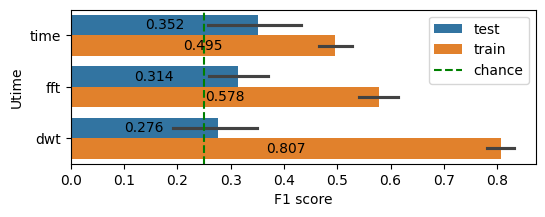

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(sharex=True, figsize=(6, 2))
sns.barplot(
    data=models_CV_scores,
    y="Utime",
    x="F1 score",
    # order=get_top_X_model_params_combos(
    #     X, df, smaller_is_better=smaller_is_better, by=by
    # ),
    hue="data",
    # palette="colorblind",
)
for i in ax.containers:
    ax.bar_label(i, fmt="{:.3}", label_type="center")
plt.axvline(0.25, label="chance", ls="--", c="green")
plt.legend(
    loc="upper right", fancybox=True
)

plt.savefig(r"../figures/utime_3best_clf.png" ,dpi = 400, bbox_inches = "tight")